#  MLP Autoencoder for MNIST dataset
# + 
# Static plots for training and latent interpolation

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.distributions as torchD

import torch, seaborn as sns
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

from utils import *

In [2]:
# # set seed for reproducibility
# seed = 24
# torch.manual_seed(seed)
# np.random.seed(seed)

## Load Dataset

In [3]:
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

In [4]:
batch_size = 128

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="../data/", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(
    root="../data/", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Autoencoder
A much simpler MLP autoencoder is used. <br/>
Separate Encoder and Decoder modules for easier "forward" function

In [ ]:
class MLP_Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(MLP_Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=np.prod(kwargs["input_shape"]), out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=kwargs["latent_dim"])
        )
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        latent = self.model(x)
        return latent

class MLP_Decoder(nn.Module):
    def __init__(self, **kwargs):
        super(MLP_Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=kwargs["latent_dim"], out_features=400),
            nn.ReLU(),
            nn.Linear(in_features=400, out_features=np.prod(kwargs["input_shape"])),
            nn.Sigmoid() # push the pixels in range (0,1)
        )
        self.output_shape = kwargs["input_shape"]
    
    def forward(self, latent):
        x_bar = self.model(latent)
        x_bar = x_bar.view([-1]+ self.output_shape)      
        return x_bar
    
class MLP_AE(nn.Module):
    def __init__(self, **kwargs):
        # kwargs["input_shape"] = [1,28,28]
        # kwargs["latent_dim"] = 4
        super(MLP_AE, self).__init__()
        self.encoder = MLP_Encoder(**kwargs)
        self.decoder = MLP_Decoder(**kwargs)
        
    def forward(self, x):
        latent = self.encoder(x)
        x_bar = self.decoder(latent)
        return latent, x_bar

    def sample_latent_embedding(self, latent, sd=1, N_samples=1):
        """
        AE returns scalar value and we use that as mean and predefined default value for standard deviation (sd)
        """
        dist = torchD.Normal(latent, sd)
        embedding = dist.sample((N_samples,))
        return embedding

## Training process

In [8]:
def train(model, device, train_loader, num_epochs=5, learning_rate=1e-3):
    recon_loss_fn = nn.BCELoss(reduction="sum")
    optimizer = optim.Adam(model.parameters(),
                          lr=learning_rate,
#                           weight_decay=1e-5,
                          )
    
    epoch_train_loss = []
    epoch_sample_img = []
    epoch_sample_reconstruction = []
    epoch_sample_latent = []
    
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0
        for img, label in train_loader:
            optimizer.zero_grad()
            
            img, label = img.to(device), label.to(device)
            
            latent, reconstruction = model(img)
            loss = recon_loss_fn(reconstruction, img)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
        train_loss = train_loss/len(train_loader)
        if (epoch<5) or (epoch%5 == 0):
            print("Epoch {}, Loss {:.4f}".format(epoch+1, float(train_loss)))
        
        epoch_train_loss.append(train_loss)
        epoch_sample_img.append(img.cpu().detach().numpy())
        epoch_sample_reconstruction.append(reconstruction.cpu().detach().numpy())
        epoch_sample_latent.append(latent.cpu().detach().numpy())
        
        results_dict = {
            "train_loss": np.array(epoch_train_loss),
            "sample_img": np.array(epoch_sample_img),
            "sample_reconstruction": np.array(epoch_sample_reconstruction),
            "sample_latent": np.array(epoch_sample_latent),
        }
        
    return model, results_dict   

In [9]:
# use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape = [1, 28, 28]
latent_dim = 2
num_epochs = 50
learning_rate = 1e-3
logDir = "models_and_stats/"
model_name = "MLP_AE_l2"
model_path = logDir + model_name + ".pt"
dict_name = model_name + '.pkl'

In [10]:
pretrain = True

In [11]:
%%time
if pretrain:
    # load the pretrained model
    model = MLP_AE(input_shape=input_shape, latent_dim=latent_dim)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    results_dict = pickle.load(open(logDir + dict_name, 'rb'))
    
else:
    # train and save the model
    model = MLP_AE(input_shape=input_shape, latent_dim=latent_dim).to(device)
    model, results_dict = train(model, device, train_loader, num_epochs=num_epochs)
    torch.save(model.state_dict(), model_path)
    pickle.dump(results_dict, open(logDir + dict_name, 'wb'))
    print("dump results dict to {}".format(dict_name))
    
model.eval()

CPU times: user 764 ms, sys: 351 ms, total: 1.12 s
Wall time: 1.11 s


MLP_AE(
  (encoder): MLP_Encoder(
    (model): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=2, bias=True)
    )
  )
  (decoder): MLP_Decoder(
    (model): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)

## Visualization of the training process and results

### plot the learning curve

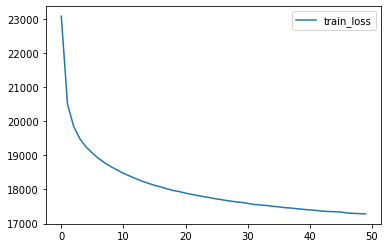

In [12]:
epoch_train_loss = results_dict["train_loss"]
assert len(epoch_train_loss)==num_epochs, "check num_epochs"
plt.plot(np.arange(num_epochs), epoch_train_loss, label="train_loss")
plt.legend()
plt.show()

### plot the evolution of reconstruction through epochs

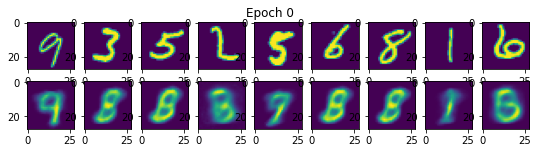

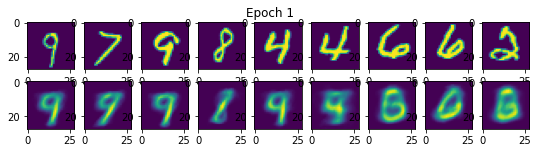

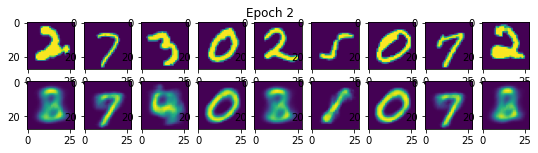

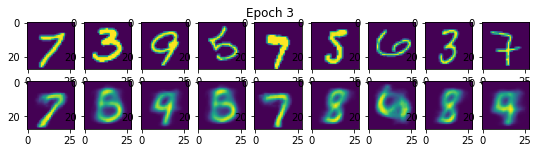

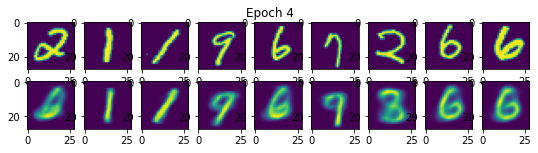

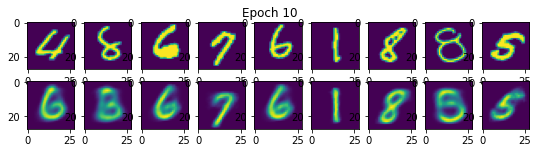

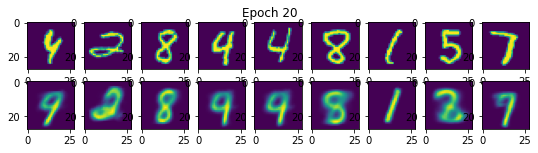

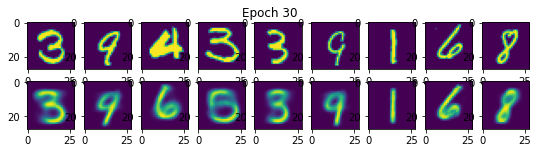

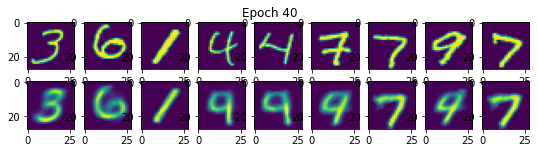

In [13]:
num_cols = 9
selected_epochs = np.concatenate((np.arange(5),np.arange(10,num_epochs,10)))
for epoch in selected_epochs:
    figure = plt.figure(figsize=(num_cols,2))
    figure.suptitle("Epoch {}".format(epoch))
    imgs = results_dict["sample_img"][epoch]
    reconstructions = results_dict["sample_reconstruction"][epoch]
    for i, item in enumerate(imgs):
        # plot only first few images
        if i>=num_cols: break
        plt.subplot(2,num_cols, i+1)
        plt.imshow(item[0])
    
    for i, item in enumerate(reconstructions):
        if i>=num_cols: break
        plt.subplot(2, num_cols, num_cols+i+1)
        plt.imshow(item[0])

### plot the latent space
The hover part takes reference from [this post](https://github.com/gr-b/autoencoder-latent-space-visualization)

In [14]:
model.eval()
sample_train_imgs, sample_train_labels = next(iter(train_loader))
print(sample_train_imgs.shape, sample_train_labels.shape)
sample_test_imgs, sample_test_labels = next(iter(test_loader))
print(sample_test_imgs.shape, sample_test_labels.shape)
sample_train_imgs, sample_test_imgs = torch.tensor(sample_train_imgs).float().to(device), torch.tensor(sample_test_imgs).float().to(device)

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])


labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


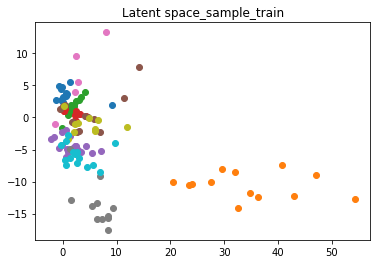

labels <class 'numpy.ndarray'> (128,)
latents <class 'numpy.ndarray'> (128, 2)


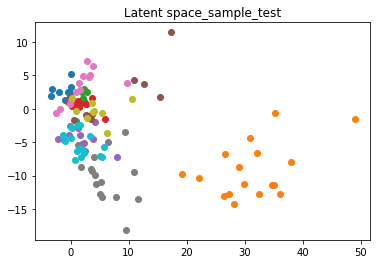

In [15]:
sample_train_latents, sample_train_reconstructions = model(sample_train_imgs)
sample_test_latents, sample_test_reconstructions = model(sample_test_imgs)
plot_latent(sample_train_labels, sample_train_latents, dtype="tensor", suptitle_app="_sample_train")
plot_latent(sample_test_labels, sample_test_latents, dtype="tensor", suptitle_app="_sample_test")

labels <class 'numpy.ndarray'> (10000,)
latents <class 'numpy.ndarray'> (10000, 2)


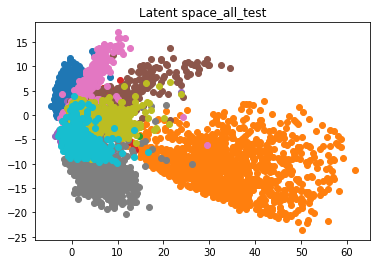

In [16]:
# plot the whole test latent space
all_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=True)
all_test_imgs, all_test_labels = next(iter(all_test_loader))
all_test_imgs = torch.tensor(all_test_imgs).float().to(device)
all_test_latents, all_test_reconstructions = model(all_test_imgs)
plot_latent(all_test_labels, all_test_latents, dtype="tensor", suptitle_app="_all_test")

In [17]:
all_test_latents = all_test_latents.cpu().detach().numpy()
all_test_labels = all_test_labels.cpu().detach().numpy()

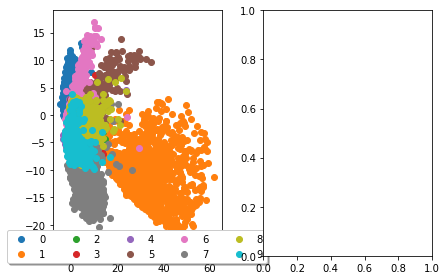

In [18]:
import PyQt5
%matplotlib qt 
# interactive hovering

fig, ax = plt.subplots(1, 2)
plt.tight_layout()
for y in np.unique(all_test_labels):
    i = np.where(all_test_labels == y)
    ax[0].scatter(all_test_latents[i,0], all_test_latents[i,1], label=y, cmap="tab10")
    ax[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
    
def onclick(event):
    global flag
    if event.xdata is None or event.ydata is None:
        return
    ix, iy = int(event.xdata), int(event.ydata)
    
    latent_vector = np.array([[ix, iy]])
    latent_vector = torch.from_numpy(latent_vector).float().to(device)
    decoded_img = model.decoder(latent_vector)
    decoded_img = decoded_img.cpu().detach().numpy()[0][0] # [1,1,28,28] => [28,28]
    ax[1].imshow(decoded_img)
    plt.draw()

# button_press_event
# motion_notify_event
cid = fig.canvas.mpl_connect('motion_notify_event', onclick)

plt.show() 

### Interpolation between any two images

In [19]:
%matplotlib inline

In [20]:
def interpolate(index1, index2):
    x1 = results_dict["sample_img"][-1][index1]
    x2 = results_dict["sample_img"][-1][index2]
    x1, x2 = torch.from_numpy(x1).float().to(device), torch.from_numpy(x2).float().to(device)
    x = torch.stack([x1, x2])
    embedding = model.encoder(x)
    e1 = embedding[0]
    e2 = embedding[1]
    
    embedding_values = []
    for i in range(10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)
    recon_from_embeddings = model.decoder(embedding_values) # shape [10, 1, 28, 28]
    
    plt.figure(figsize=(10,2))
    for i, recon in enumerate(recon_from_embeddings.cpu().detach().numpy()):
        plt.subplot(2, 10, i+1)
        plt.imshow(recon[0])
    # plot two original images
    plt.subplot(2, 10, 11)
    plt.imshow(x2.cpu().detach().numpy()[0])
    plt.subplot(2, 10, 20)
    plt.imshow(x1.cpu().detach().numpy()[0])

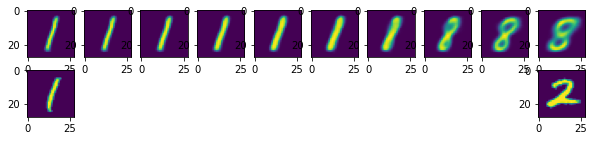

In [21]:
interpolate(3,5)

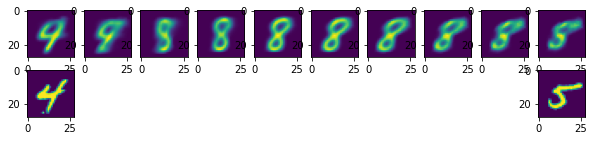

In [22]:
interpolate(2,7)

### Interactive scroll bar for latent space

see AE_MNIST_Interactive_ScrollBar

### Sampling around latent z
Assume Gaussian $\mathcal{N}(\mu,\,\sigma^{2})$ = $\mathcal{N}(0, 1)$ for each $z_i$

In [23]:
indexes = [1, 5, 8, 30]
N_samples = 10

In [24]:
def sample_latent_embedding(latent, sd=1, N_samples=1):
    """
    AE returns scalar value and we use that as mean and predefined default value for standard deviation (sd)
    equivalently, use model.sample_latent_embedding
    """
    dist = torchD.Normal(latent, sd)
    embedding = dist.sample((N_samples,))
#         print("sample z for AE, sample_shape {}, batch_shape {}, event_shape {}".format(embedding.shape, dist.batch_shape, dist.event_shape))
    return embedding

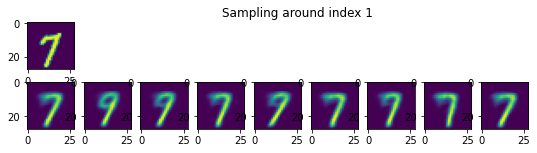

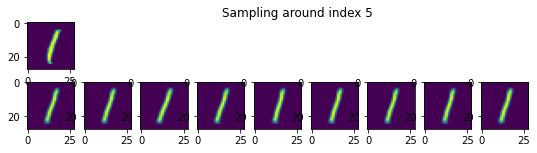

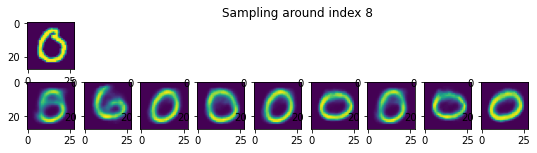

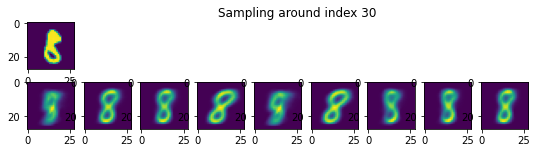

In [25]:
for index in indexes:
    x = results_dict["sample_img"][-1][index]
    x = torch.from_numpy(x).float().to(device)
    x = torch.unsqueeze(x, 0)

    latent = model.encoder(x)
    sample_z = sample_latent_embedding(latent, sd=1, N_samples=N_samples-1)
    recon_sample_z = model.decoder(sample_z)
    
    figure = plt.figure(figsize=(N_samples,2))
    figure.suptitle("Sampling around index {}".format(index))
    img = results_dict["sample_img"][-1][index]
    reconstruction = results_dict["sample_reconstruction"][-1][index]
    
    plt.subplot(2, N_samples, 1)
    plt.imshow(img[0])    
    plt.subplot(2, N_samples, N_samples+1)
    plt.imshow(reconstruction[0])
    
    for i, recon in enumerate(recon_sample_z.cpu().detach().numpy()):
        plt.subplot(2, N_samples, N_samples+i+1)
        plt.imshow(recon[0])
